In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
import pickle
from optbinning import scorecard

In [4]:
X_train = pd.read_csv('../03_outputs/02/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('../03_outputs/02/y_train.csv', index_col='Unnamed: 0')
X_test = pd.read_csv('../03_outputs/02/X_test.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('../03_outputs/02/y_test.csv', index_col='Unnamed: 0')

# Model Development

In [2]:
# Make scorer
auc_score = make_scorer(roc_auc_score)

In [11]:
# Hyperparameter tuning: Bayesian Optimization
def xgb_cl_bo(n_estimators, max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree):
    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'nthread':-1
    }
    params_xgb['n_estimators'] = round(n_estimators)
    params_xgb['max_depth'] = round(max_depth)
    params_xgb['learning_rate'] = learning_rate
    params_xgb['gamma'] = gamma
    params_xgb['min_child_weight'] = round(min_child_weight)
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample_bytree
    params_xgb['scale_pos_weight'] = 3.5
        
    score = cross_val_score(
        XGBClassifier(random_state=123, **params_xgb), X_train, y_train, scoring=auc_score, cv=5
    ).mean()
    return score

# Set parameters distribution
params_xgb ={
    'n_estimators':(80, 150),
    'max_depth': (3, 50),
    'learning_rate': (0.01, 0.5),
    'gamma':(0, 10),
    'min_child_weight':(3, 100),
    'subsample':(0.8, 1),
    'colsample_bytree':(0.1, 1)
}

# Run Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_cl_bo, params_xgb, random_state=111)
xgb_bo.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9572    | 0.651     | 1.691     | 0.2237    | 39.16     | 31.65     | 90.44     | 0.8045    |
| 2         | 0.9574    | 0.4782    | 2.387     | 0.1755    | 49.56     | 26.06     | 85.68     | 0.9339    |
| 3         | 0.9598    | 0.6591    | 2.743     | 0.2384    | 8.563     | 10.17     | 143.1     | 0.9588    |
| 4         | 0.9446    | 0.8565    | 8.152     | 0.4956    | 30.13     | 81.94     | 109.5     | 0.8055    |
| 5         | 0.9536    | 0.5087    | 1.053     | 0.4104    | 35.79     | 57.83     | 99.2      | 0.9997    |
| 6         | 0.96      | 0.2897    | 3.393     | 0.08181   | 48.82     | 3.056     | 139.9     | 0.9801    |
| 7         | 0.9582    | 0.7524    | 2.175     | 0.05954   | 8.301     | 7.517     | 144.0     | 0.9776    |
| 8       

In [12]:
# Best hyperparameters
params_xgb = xgb_bo.max['params']
params_xgb['objective'] = 'binary:logistic'
params_xgb['n_jobs'] = -1
params_xgb['colsample_bytree'] = round(params_xgb['colsample_bytree'], 2)
params_xgb['gamma'] = round(params_xgb['gamma'], 2)
params_xgb['learning_rate'] = round(params_xgb['learning_rate'], 2)
params_xgb['max_depth'] = round(params_xgb['max_depth'])
params_xgb['min_child_weight'] = round(params_xgb['min_child_weight'])
params_xgb['n_estimators'] = round(params_xgb['n_estimators'])
params_xgb['subsample'] = round(params_xgb['subsample'], 2)

params_xgb

{'colsample_bytree': 0.29,
 'gamma': 3.39,
 'learning_rate': 0.08,
 'max_depth': 49,
 'min_child_weight': 3,
 'n_estimators': 140,
 'subsample': 0.98,
 'objective': 'binary:logistic',
 'n_jobs': -1}

In [32]:
# Fit the training data
xgb_hyp =  XGBClassifier(**params_xgb, random_state=123, nthread=-1)
xgb_hyp.fit(X_train, y_train)

# Predict the test data probability
prob_train = xgb_hyp.predict_proba(X_train)[:, 1]
prob_test = xgb_hyp.predict_proba(X_test)[:, 1]

# Model Evaluation

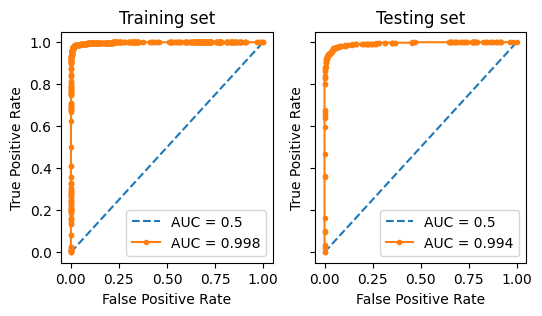

In [34]:
# compute auc scores
ns_prob = [0 for _ in range(len(y_train))]
ns_auc = roc_auc_score(y_train, ns_prob)
xgb_auc_train = roc_auc_score(y_train, prob_train)
xgb_auc_val = roc_auc_score(y_test, prob_test)

# plot the roc curve 
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_prob)
train_fpr, train_tpr, _ = roc_curve(y_train, prob_train)
val_fpr, val_tpr, _ = roc_curve(y_test, prob_test)

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharey=True)

title_list = ['Training set', 'Testing set']
for col, fpr, tpr, auc_score in zip([0, 1], [train_fpr, val_fpr], [train_tpr, val_tpr], [xgb_auc_train, xgb_auc_val]):
    ax[col].plot(ns_fpr, ns_tpr, linestyle='--', label='AUC = 0.5')
    ax[col].plot(fpr, tpr, marker='.', label='AUC = %.3f' % (auc_score))
    ax[col].set_title(title_list[col])
    ax[col].set_xlabel('False Positive Rate')
    ax[col].set_ylabel('True Positive Rate')
    ax[col].legend()

plt.show()

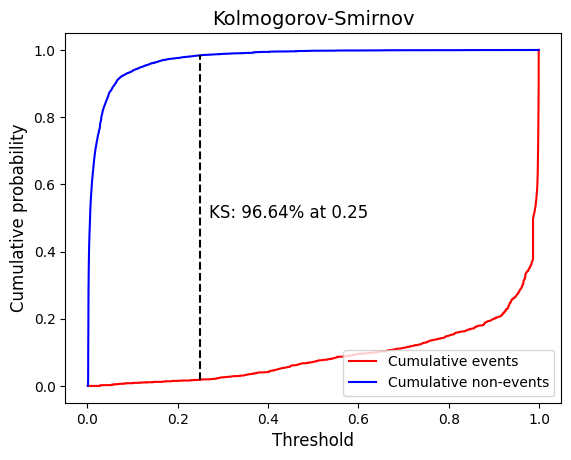

In [17]:
# Find the score threshold based on KS Plot
scorecard.plot_ks(y_train, prob_train)

In [37]:
pred_train.head()

,probability,true,prediction
1598,0.001699,NaN,0
5559,0.027818,NaN,0
4175,0.004055,NaN,0
8500,0.961750,NaN,1
3685,0.010911,NaN,0


In [57]:
threshold = 0.25

pred_train = pd.DataFrame(prob_train, index=y_train.index)
pred_train.columns = ['probability']
pred_train['true'] = y_train['flag'].values
pred_train['prediction'] = np.where(pred_train['probability'] > threshold, 1, 0)

pred_test = pd.DataFrame(prob_test)
pred_test.columns = ['probability']
pred_test['true'] = y_test['flag'].values
pred_test['prediction'] = np.where(pred_test['probability'] > threshold, 1, 0)

In [60]:
# Model Evaluation
print('==== Training set')
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_train, pred_train['prediction'])))
print(classification_report(y_train, pred_train['prediction']))

==== Training set
Confusion Matrix
      0     1
0  6019    96
1    31  1712
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6115
           1       0.95      0.98      0.96      1743

    accuracy                           0.98      7858
   macro avg       0.97      0.98      0.98      7858
weighted avg       0.98      0.98      0.98      7858



In [61]:
# Model Evaluation
print('==== Testing set')
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_test, pred_test['prediction'])))
print(classification_report(y_test, pred_test['prediction']))

==== Testing set
Confusion Matrix
      0    1
0  1483   46
1    23  413
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1529
           1       0.90      0.95      0.92       436

    accuracy                           0.96      1965
   macro avg       0.94      0.96      0.95      1965
weighted avg       0.97      0.96      0.97      1965



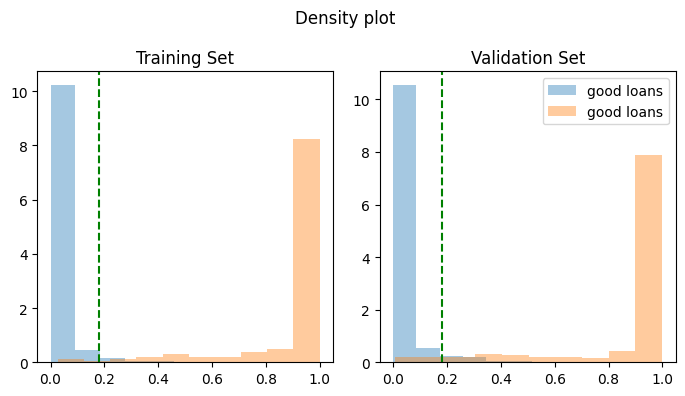

In [62]:
# Plot the histogram of how good and bad loans are separated
fig, ax = plt.subplots(1, 2, figsize=(7,4))

ax[0].hist(pred_train.loc[pred_train['true']==0, 'probability'], density=True, alpha=0.4, bins=10)
ax[0].hist(pred_train.loc[pred_train['true']==1, 'probability'], density=True, alpha=0.4, bins=10)
ax[0].axvline(x=0.18, linestyle='--', color='green')
ax[0].set_title('Training Set')

ax[1].hist(pred_test.loc[pred_test['true']==0, 'probability'], density=True, alpha=0.4, bins=10, label='good loans')
ax[1].hist(pred_test.loc[pred_test['true']==1, 'probability'], density=True, alpha=0.4, bins=10, label='good loans')
ax[1].set_title('Validation Set')
ax[1].axvline(x=0.18, linestyle='--', color='green')
ax[1].legend()

fig.suptitle('Density plot')
plt.tight_layout()
plt.show()

# Feature Importance

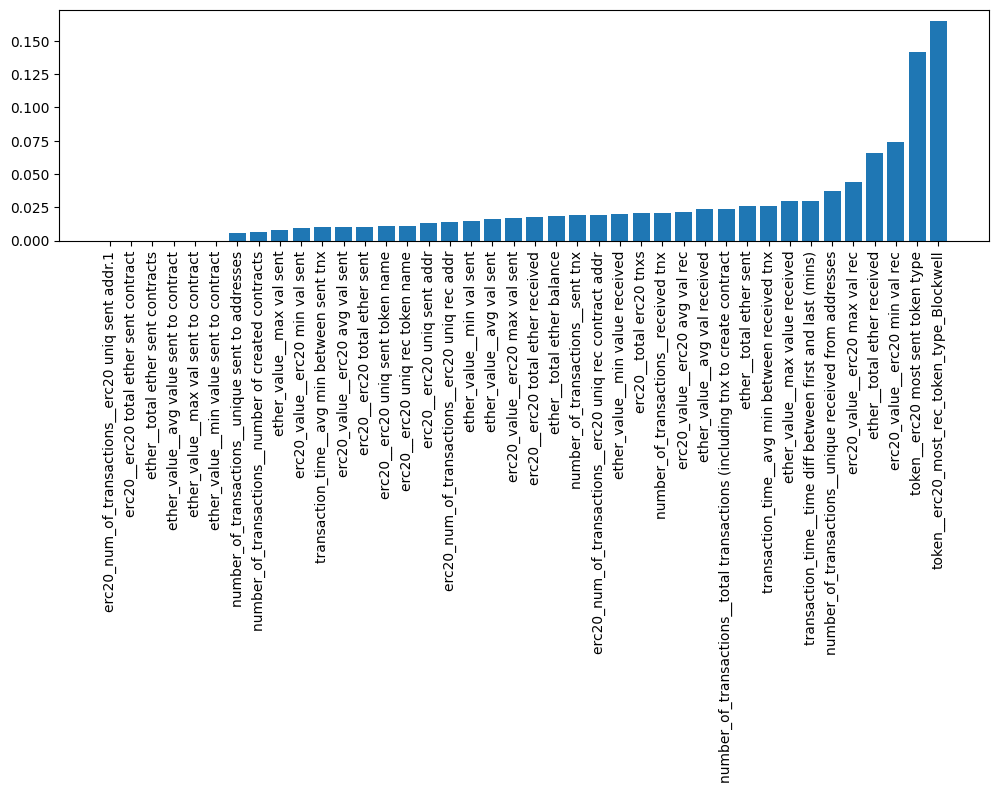

In [63]:
# Feature importances
FeatureXgb = pd.DataFrame({'feature':X_train.columns, 'importance':list(xgb_hyp.feature_importances_)}).sort_values('importance')
plt.figure(figsize=(12,3))
plt.bar(x=FeatureXgb['feature'], height=FeatureXgb['importance'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Save
pickle.dump(xgb_hyp, open('../03_outputs/03/xgb_fraud.pkl', 'wb'))

pred_train.index = y_train.index
pred_train.to_csv('../03_outputs/03/pred_train.csv')

pred_test.index = y_test.index
pred_test.to_csv('../03_outputs/03/pred_test.csv')